<a href="https://colab.research.google.com/github/Tarasqua/prime_human_recognition/blob/master/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# Function to download an image from a URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Download the image
url = 'https://i.pinimg.com/originals/83/de/4b/83de4b3706360674108710d4339133f8.jpg'
image = download_image(url)

# Initialize the super-resolution model
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel('/content/drive/MyDrive/EDSR_x4.pb')  # Using EDSR_x4 for higher quality upscaling
sr.setModel('edsr', 4)  # 4x upscaling

# Upscale the image
upscaled_image = sr.upsample(image)

# Save the upscaled image
output_path = 'upscaled_image.png'
cv2.imwrite(output_path, upscaled_image)

In [ ]:
! pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 717.8 kB/s eta 0:00:00


In [ ]:
import os
import random
from pathlib import Path
from typing import List, Tuple, Iterator

import cv2
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Flatten, Dense, \
    Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET = Path.cwd() / 'drive' / 'MyDrive' / 'preprocessed_grayscale'
logger.success('Dataset found') if (exists := os.path.exists(DATASET)) else logger.error('Dataset not found')

2024-06-13 11:05:13.256 | SUCCESS  | __main__:<cell line: 2>:2 - Dataset found


In [ ]:
def visualize_sample_images(folder_path: str, max_images: int = 5) -> None:
    """
    Визуализируем изображения в папке.
    :param folder_path: Путь до папки.
    :param max_images: Максимальное количество изображений.
    :return: None.
    """
    images = os.listdir(folder_path)[:max_images]
    num_images = len(images)
    num_rows = (num_images + 4) // 5
    num_cols = min(num_images, 5)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)
        sample_image = cv2.imread(image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        row = i // num_cols
        col = i % num_cols
        if num_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        ax.imshow(sample_image)
        ax.axis('off')

    for ax in axes.flat[num_images:]:
        ax.remove()

    plt.suptitle(f'Person ID: {os.path.basename(folder_path)}')
    plt.tight_layout()
    plt.show()

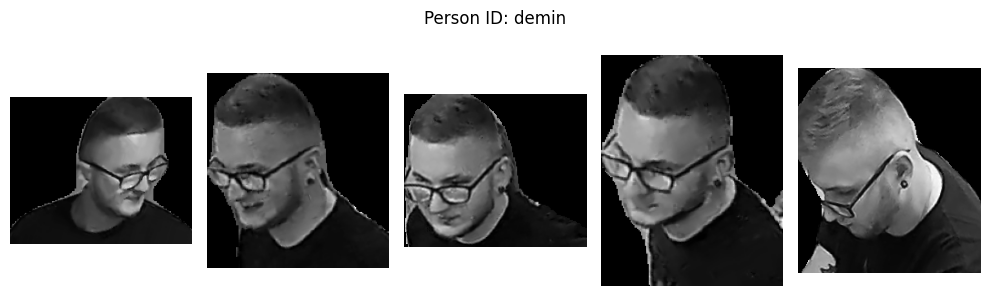

In [ ]:
visualize_sample_images(random.choice([os.path.join(DATASET, folder_name) for folder_name in os.listdir(DATASET)]))

In [ ]:
def triplets(folder_paths, max_triplets=7) -> Tuple[List, List, List]:
    """
    Создание триплетов.
    :param folder_paths: Пути до папок.
    :param max_triplets: Максимальное количество триплетов.
    :return: Списки триплетов в формате: якорные, достоверные, недостоверные.
    """
    anchor_images = []
    positive_images = []
    negative_images = []

    for person_folder in folder_paths:
        images = [os.path.join(person_folder, img) for img in os.listdir(person_folder)]
        num_images = len(images)
        if num_images < 2:
            continue
        random.shuffle(images)
        for _ in range(max(num_images - 1, max_triplets)):
            anchor_image = random.choice(images)
            positive_image = random.choice([x for x in images if x != anchor_image])
            negative_folder = random.choice([x for x in folder_paths if x != person_folder])
            negative_image = random.choice([os.path.join(negative_folder, img)
                                            for img in os.listdir(negative_folder)])
            anchor_images.append(anchor_image)
            positive_images.append(positive_image)
            negative_images.append(negative_image)

    return anchor_images, positive_images, negative_images

In [ ]:
people_folders = [os.path.join(DATASET, folder_name) for folder_name in os.listdir(DATASET)]
anchors, positives, negatives = triplets(people_folders)

In [ ]:
def split_triplets(anchors_, positives_, negatives_, validation_split=0.2) -> Tuple[List, List]:
    """
    Разбиение триплетов на тренировочные и валидационные.
    :param anchors_: Список якорных триплетов.
    :param positives_: Достоверные триплеты.
    :param negatives_: Недостоверные триплеты.
    :param validation_split: Доля валидационных данных.
    :return: Тренировочные и валидационные триплеты в формате: [(якорное изображение, достоверное, недостоверное), (...)].
    """
    triplets_ = list(zip(anchors_, positives_, negatives_))
    train_triplets_, val_triplets_ = train_test_split(triplets_, test_size=validation_split, random_state=42)
    return train_triplets_, val_triplets_

In [ ]:
train_triplets, val_triplets = split_triplets(anchors, positives, negatives)
len(train_triplets), len(val_triplets)

(672, 168)

In [ ]:
def load_and_preprocess_image(image_path, expand_dims=False) -> np.array:
    """
    Подгрузка и предобработка изображений: BGR -> RGB + resize(128, 128).
    :param image_path: Путь до изображения.
    :param expand_dims: Увеличивает размерность изображения.
    :return: Изображение в формате np.array.
    """
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"Error loading image {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    return image

In [ ]:
def batch_generator(triplets_: List[Tuple], batch_size_: int = 32, augment: bool = True) -> Iterator[List[np.array]]:
    """
    Генератор батчей.
    :param triplets_: Список всех триплетов
    :param batch_size_:
    :param augment:
    :return:
    """
    total_triplets = len(triplets_)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)

    augmentator = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        zoom_range=0.2
    )
    empty_triplet = False  # отслеживаем, что с текущим триплетом все в порядке

    while True:
        for i in range(0, total_triplets, batch_size_):
            batch_indices = random_indices[i:i + batch_size_]
            batch_triplets = [triplets_[j] for j in batch_indices]

            anchor_batch = []
            positive_batch = []
            negative_batch = []

            for triplet in batch_triplets:
                anchor, positive, negative = triplet
                if ((anchor_image := load_and_preprocess_image(anchor)) is None or
                        (positive_image := load_and_preprocess_image(positive)) is None or
                        (negative_image := load_and_preprocess_image(negative)) is None):
                    logger.error(f'Triplet {triplet} contains an invalid image')
                    empty_triplet = True
                    break

                if augment:
                    anchor_image = augmentator.random_transform(anchor_image)
                    positive_image = augmentator.random_transform(positive_image)
                    negative_image = augmentator.random_transform(negative_image)

                anchor_batch.append(anchor_image)
                positive_batch.append(positive_image)
                negative_batch.append(negative_image)

            if empty_triplet:
                continue

            yield [np.array(anchor_batch),
                   np.array(positive_batch),
                   np.array(negative_batch)], np.zeros((batch_size_,))  # dummy labels

In [ ]:
def visualize_triplets(triplet) -> None:
    """
    Визуализация триплетов.
    :param triplet: Триплет.
    :return: None.
    """
    (anchor_batch, positive_batch, negative_batch), _ = triplet

    for i in range(len(anchor_batch)):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Anchor")
        plt.imshow(anchor_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        plt.imshow(positive_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        plt.imshow(negative_batch[i])
        plt.axis('off')

        plt.show()

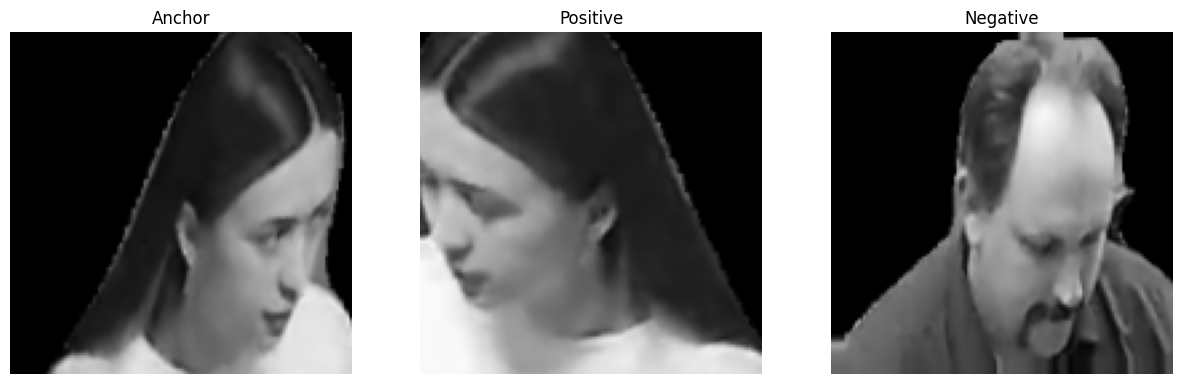

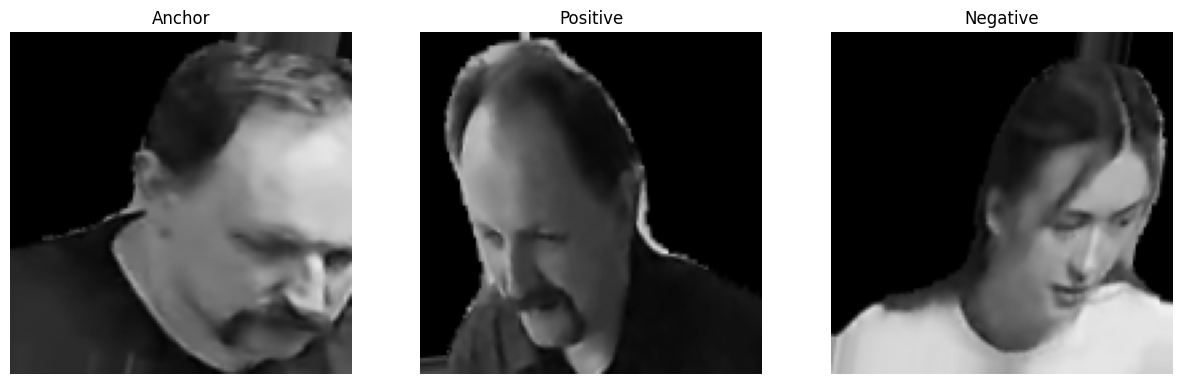

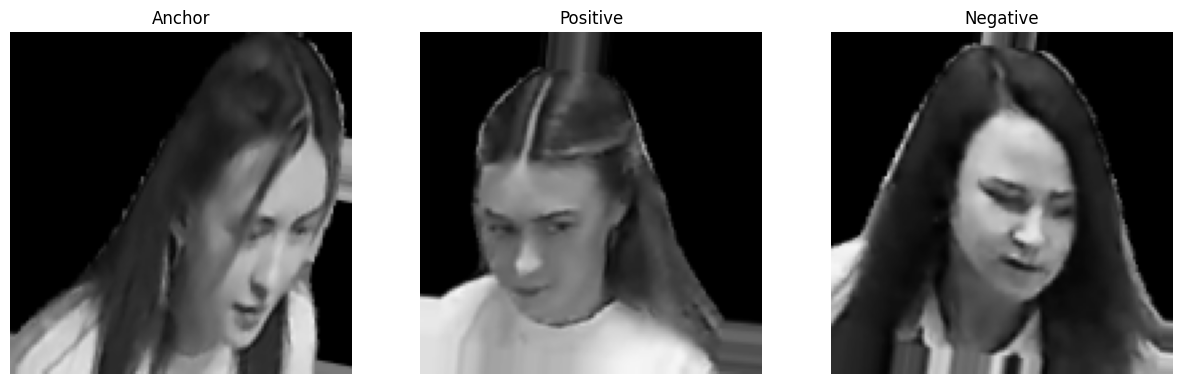

In [ ]:
example_triplets = [next(batch_generator(train_triplets, batch_size_=3))]
visualize_triplets(example_triplets[0])

In [ ]:
def triplet_loss(margin=1.0):
    def _triplet_loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:128], y_pred[:, 128:256], y_pred[:, 256:384]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)
    return _triplet_loss

In [ ]:
def get_embedding(input_shape_: Tuple[int, int, int], num_layers_to_unfreeze: int = 25) -> tf.keras.models.Sequential:
    """
    Создание модели для получения эмбеддингов.
    :param input_shape_: Входное разрешение.
    :param num_layers_to_unfreeze: Количество слоев, которые будут разблокированы.
    :return: Модель для эмбеддингов.
    """
    emb_model = EfficientNetB7(weights='imagenet', input_shape=input_shape_, include_top=False, pooling='avg')

    for i in range(len(emb_model.layers) - num_layers_to_unfreeze):
        emb_model.layers[i].trainable = False

    emb = tf.keras.models.Sequential([
        emb_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128)
    ], name='Embedding')

    return emb

In [ ]:
def create_siamese_model(input_shape_):
    embedding_model = get_embedding(input_shape_)

    anchor_input = Input(input_shape_, name="anchor_input")
    positive_input = Input(input_shape_, name="positive_input")
    negative_input = Input(input_shape_, name="negative_input")

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    merged_output = Lambda(lambda embeddings: tf.concat(embeddings, axis=1))([anchor_embedding, positive_embedding, negative_embedding])

    siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)
    return siamese_model

In [ ]:
input_shape = (128, 128, 3)
siamese_model = create_siamese_model(input_shape)
siamese_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))

258076736/258076736 [==============================] - 2s 0us/step


In [ ]:
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                              

In [ ]:
class DistanceMonitoringCallback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        anchor_embeds = []
        positive_embeds = []
        negative_embeds = []

        for batch in self.val_data:
            anchor, positive, negative = batch
            anchor_embed = self.model.predict(anchor)
            positive_embed = self.model.predict(positive)
            negative_embed = self.model.predict(negative)
            anchor_embeds.append(anchor_embed)
            positive_embeds.append(positive_embed)
            negative_embeds.append(negative_embed)

        anchor_embeds = np.vstack(anchor_embeds)
        positive_embeds = np.vstack(positive_embeds)
        negative_embeds = np.vstack(negative_embeds)

        pos_distances = np.linalg.norm(anchor_embeds - positive_embeds, axis=1)
        neg_distances = np.linalg.norm(anchor_embeds - negative_embeds, axis=1)

        avg_pos_distance = np.mean(pos_distances)
        avg_neg_distance = np.mean(neg_distances)

        logger.info(f"Epoch {epoch+1}: Average Positive Distance = {avg_pos_distance}, Average Negative Distance = {avg_neg_distance}")

In [ ]:
batch_size = int(len(train_triplets) ** (1. / 3))  # cube root

train_gen = batch_generator(train_triplets, batch_size_=batch_size, augment=True)
val_gen = batch_generator(val_triplets, batch_size_=batch_size, augment=False)
# distance_monitoring_cb = DistanceMonitoringCallback(list(val_gen))
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
siamese_model.fit(train_gen,
                  validation_data=val_gen,
                  steps_per_epoch=len(train_triplets) // batch_size,
                  validation_steps=len(val_triplets) // batch_size,
                  epochs=200,
                  callbacks=[early_stopping_cb])

Epoch 1/200
84/84 [==============================] - 680s 7s/step - loss: 13.9234 - val_loss: 26.0134
Epoch 2/200
84/84 [==============================] - 618s 7s/step - loss: 9.3902 - val_loss: 16.8820
Epoch 3/200
84/84 [==============================] - 584s 7s/step - loss: 8.0521 - val_loss: 27.1549
Epoch 4/200
84/84 [==============================] - 585s 7s/step - loss: 7.7697 - val_loss: 27.0277
Epoch 5/200
84/84 [==============================] - 585s 7s/step - loss: 5.3673 - val_loss: 3.5367
Epoch 6/200
84/84 [==============================] - 525s 6s/step - loss: 3.0911 - val_loss: 6.0534
Epoch 7/200
84/84 [==============================] - 530s 6s/step - loss: 4.1023 - val_loss: 3.3384
Epoch 8/200
84/84 [==============================] - 584s 7s/step - loss: 3.0340 - val_loss: 3.2182
Epoch 9/200
84/84 [==============================] - 585s 7s/step - loss: 2.5467 - val_loss: 3.4173
Epoch 10/200
84/84 [==============================] - 584s 7s/step - loss: 1.8807 - val_loss: 1

In [ ]:
siamese_model.save('siamese_model')
embedding_model = siamese_model.get_layer('Embedding')
embedding_model.save('embedding_model')

KeyboardInterrupt: 

In [ ]:
siamese_model.save((Path.cwd() / 'drive' / 'MyDrive' / 'siamese_model').as_posix())
embedding_model = siamese_model.get_layer('Embedding')
embedding_model.save((Path.cwd() / 'drive' / 'MyDrive' / 'embedding_model').as_posix())

6/6 [==============================] - 31s 5s/step


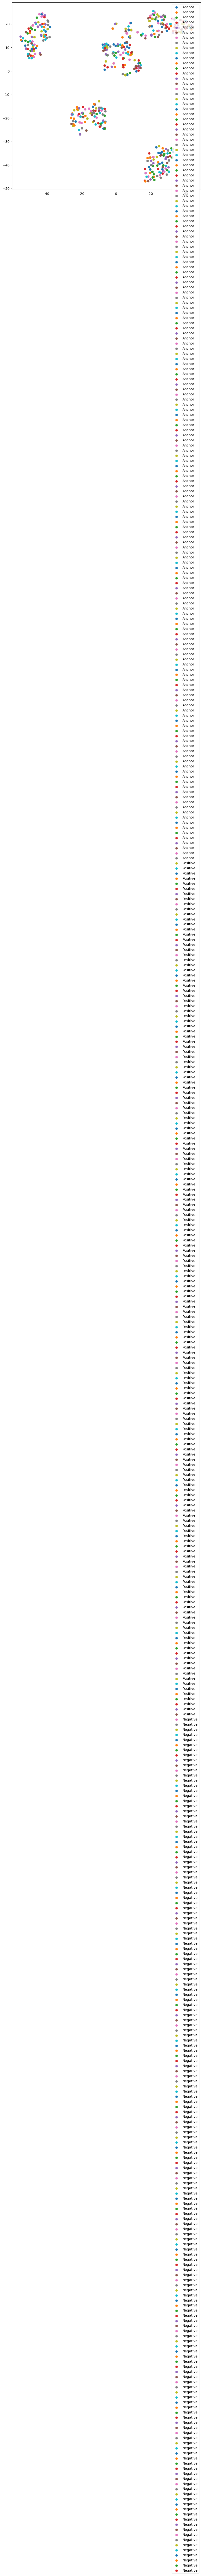

In [ ]:
from sklearn.manifold import TSNE

def plot_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    for i in range(len(labels)):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=labels[i])
    plt.legend()
    plt.show()

anchor_images = [load_and_preprocess_image(triplet[0], expand_dims=True) for triplet in val_triplets]
positive_images = [load_and_preprocess_image(triplet[1], expand_dims=True) for triplet in val_triplets]
negative_images = [load_and_preprocess_image(triplet[2], expand_dims=True) for triplet in val_triplets]

embedding_model = siamese_model.get_layer('Embedding')

anchor_embeddings = embedding_model.predict(np.vstack(anchor_images))
positive_embeddings = embedding_model.predict(np.vstack(positive_images))
negative_embeddings = embedding_model.predict(np.vstack(negative_images))

# Combine embeddings and labels for visualization
all_embeddings = np.vstack((anchor_embeddings, positive_embeddings, negative_embeddings))
all_labels = ['Anchor'] * len(anchor_embeddings) + ['Positive'] * len(positive_embeddings) + ['Negative'] * len(negative_embeddings)

# Plot embeddings
plot_embeddings(all_embeddings, all_labels)

In [ ]:
def evaluate_embeddings(model, test_triplets):
    anchor_images = [load_and_preprocess_image(triplet[0], expand_dims=True) for triplet in test_triplets]
    positive_images = [load_and_preprocess_image(triplet[1], expand_dims=True) for triplet in test_triplets]
    negative_images = [load_and_preprocess_image(triplet[2], expand_dims=True) for triplet in test_triplets]

    anchor_embeddings = model.predict(np.vstack(anchor_images))
    positive_embeddings = model.predict(np.vstack(positive_images))
    negative_embeddings = model.predict(np.vstack(negative_images))

    pos_distances = np.linalg.norm(anchor_embeddings - positive_embeddings, axis=1)
    neg_distances = np.linalg.norm(anchor_embeddings - negative_embeddings, axis=1)

    accuracy = np.mean(pos_distances < neg_distances)
    return accuracy

# Example evaluation on test triplets
embedding_model = siamese_model.get_layer('Embedding')
test_accuracy = evaluate_embeddings(embedding_model, val_triplets)

logger.info(f"Test Accuracy: {test_accuracy}")

6/6 [==============================] - 31s 5s/step


2024-06-13 15:36:56.924 | INFO     | __main__:<cell line: 20>:20 - Test Accuracy: 0.9642857142857143


In [ ]:
siamese_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))

In [ ]:
siamese_model.save((Path.cwd() / 'drive' / 'MyDrive' / 'siamese_model_2').as_posix())
embedding_model.save((Path.cwd() / 'drive' / 'MyDrive' / 'embedding_model_2').as_posix())

In [ ]:
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'triplet_loss': triplet_loss, '_triplet_loss': triplet_loss()}):
    siamese_ = tf.keras.models.load_model((Path.cwd() / 'drive' / 'MyDrive' / 'siamese_model_2').as_posix())
    embedding_ = tf.keras.models.load_model((Path.cwd() / 'drive' / 'MyDrive' / 'embedding_model_2').as_posix())